In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_lr_finder import LRFinder

from dataset import train_loader, test_loader
from model import Net_s10, dropout_value
from train import train, test, train_losses, test_losses, train_acc, test_acc, lrs
from utils import get_incorrect_preds, plot_incorrect_preds, plot_sample_imgs

/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
(1600000, 32, 3)
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]
Files already downloaded and verified
Files already downloaded and verified
cuda available? True


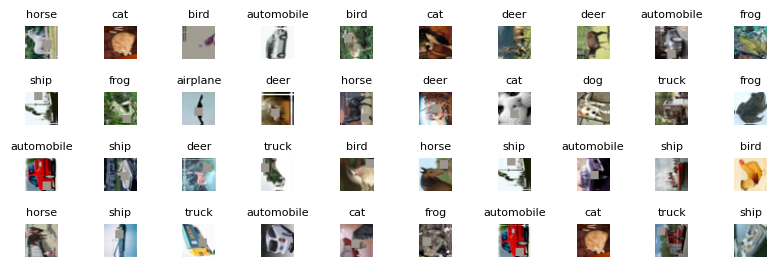

In [3]:
plot_sample_imgs(train_loader)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net_s10().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

 91%|██████████████████████████████████████▏   | 91/100 [00:13<00:01,  6.87it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.21E-04


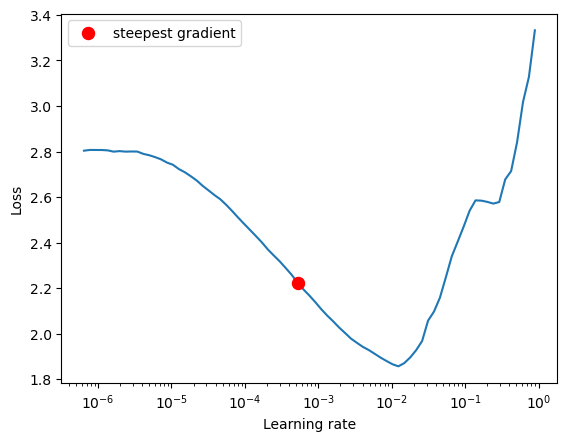

In [4]:
model =  Net_s10().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [5]:
EPOCHS = 24
model =  Net_s10().to(device)
optimizer = optim.Adam(model.parameters(), lr=5.21E-04, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=5.21E-04, 
                                          pct_start=0.2, 
                                          epochs=EPOCHS, 
                                          div_factor=100.0, 
                                          final_div_factor=100.0, 
                                          steps_per_epoch=len(train_loader))
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=1.44596266746521 Batch_id=97 Accuracy=30.36: 100%|█| 98/98 [00:14<00:00,  6



Test set: Average loss: 1.4419, Accuracy: 4757/10000 (47.57%)

EPOCH: 2


Loss=0.9368987083435059 Batch_id=97 Accuracy=56.54: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 1.0989, Accuracy: 6065/10000 (60.65%)

EPOCH: 3


Loss=0.852362871170044 Batch_id=97 Accuracy=68.08: 100%|█| 98/98 [00:14<00:00,  



Test set: Average loss: 0.8371, Accuracy: 7088/10000 (70.88%)

EPOCH: 4


Loss=0.6952371001243591 Batch_id=97 Accuracy=74.48: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.7834, Accuracy: 7396/10000 (73.96%)

EPOCH: 5


Loss=0.5348702073097229 Batch_id=97 Accuracy=78.50: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.6214, Accuracy: 7897/10000 (78.97%)

EPOCH: 6


Loss=0.4826489984989166 Batch_id=97 Accuracy=81.73: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.7381, Accuracy: 7562/10000 (75.62%)

EPOCH: 7


Loss=0.5158560872077942 Batch_id=97 Accuracy=83.67: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.6000, Accuracy: 7934/10000 (79.34%)

EPOCH: 8


Loss=0.4830436110496521 Batch_id=97 Accuracy=84.93: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.7923, Accuracy: 7452/10000 (74.52%)

EPOCH: 9


Loss=0.35775309801101685 Batch_id=97 Accuracy=86.14: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.5309, Accuracy: 8200/10000 (82.00%)

EPOCH: 10


Loss=0.3974515497684479 Batch_id=97 Accuracy=86.92: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.4816, Accuracy: 8303/10000 (83.03%)

EPOCH: 11


Loss=0.33697274327278137 Batch_id=97 Accuracy=88.20: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.4930, Accuracy: 8323/10000 (83.23%)

EPOCH: 12


Loss=0.290404736995697 Batch_id=97 Accuracy=88.93: 100%|█| 98/98 [00:14<00:00,  



Test set: Average loss: 0.4315, Accuracy: 8531/10000 (85.31%)

EPOCH: 13


Loss=0.2960453927516937 Batch_id=97 Accuracy=89.82: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.4096, Accuracy: 8624/10000 (86.24%)

EPOCH: 14


Loss=0.3341232240200043 Batch_id=97 Accuracy=90.52: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.4471, Accuracy: 8496/10000 (84.96%)

EPOCH: 15


Loss=0.26944151520729065 Batch_id=97 Accuracy=91.37: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.4709, Accuracy: 8451/10000 (84.51%)

EPOCH: 16


Loss=0.2062971442937851 Batch_id=97 Accuracy=92.52: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.3445, Accuracy: 8800/10000 (88.00%)

EPOCH: 17


Loss=0.21493162214756012 Batch_id=97 Accuracy=93.58: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.3571, Accuracy: 8804/10000 (88.04%)

EPOCH: 18


Loss=0.1773844212293625 Batch_id=97 Accuracy=94.37: 100%|█| 98/98 [00:14<00:00, 



Test set: Average loss: 0.3157, Accuracy: 8932/10000 (89.32%)

EPOCH: 19


Loss=0.12580709159374237 Batch_id=97 Accuracy=95.26: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.2646, Accuracy: 9116/10000 (91.16%)

EPOCH: 20


Loss=0.10598208010196686 Batch_id=97 Accuracy=96.62: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.2593, Accuracy: 9143/10000 (91.43%)

EPOCH: 21


Loss=0.08611941337585449 Batch_id=97 Accuracy=97.41: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.2308, Accuracy: 9249/10000 (92.49%)

EPOCH: 22


Loss=0.08625299483537674 Batch_id=97 Accuracy=98.12: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.2196, Accuracy: 9272/10000 (92.72%)

EPOCH: 23


Loss=0.07906905561685562 Batch_id=97 Accuracy=98.50: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.2138, Accuracy: 9300/10000 (93.00%)

EPOCH: 24


Loss=0.07322480529546738 Batch_id=97 Accuracy=98.60: 100%|█| 98/98 [00:14<00:00,



Test set: Average loss: 0.2118, Accuracy: 9307/10000 (93.07%)



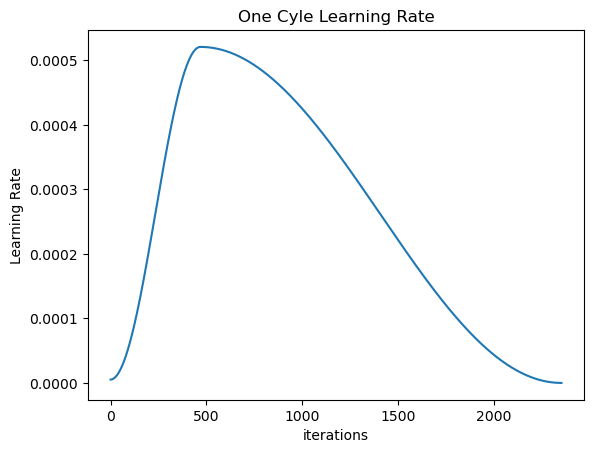

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(lrs)
plt.xlabel('iterations') 
plt.ylabel('Learning Rate') 
  
# displaying the title
plt.title("One Cyle Learning Rate")
plt.show()

Text(0.5, 1.0, 'Test Accuracy')

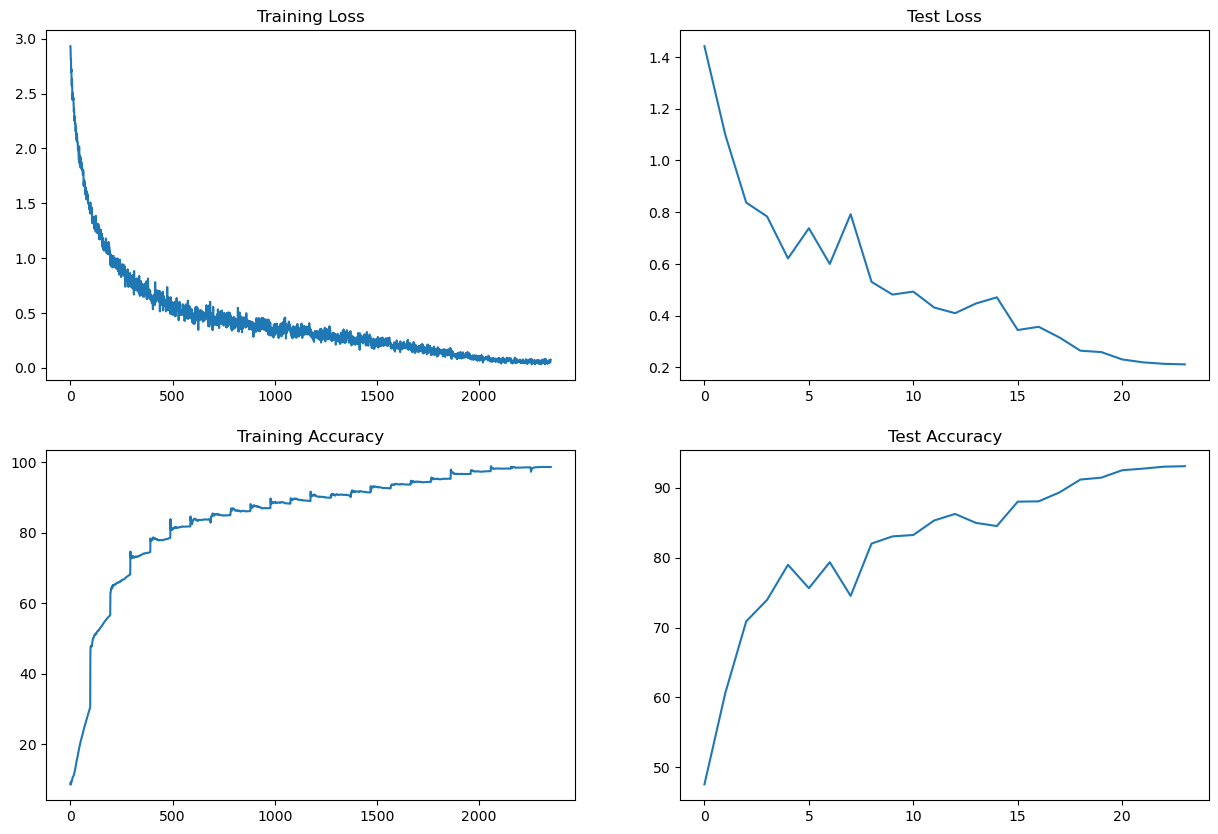

In [8]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Classes in order Actual and Predicted


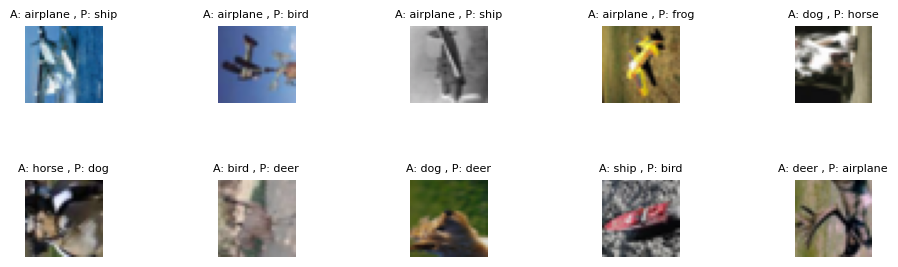

In [9]:
true_wrong, incorrect_examples, pred_wrong = get_incorrect_preds(model, test_loader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong)